# RNN Queue Imbalance

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import RNN, Dense, Input, Dropout, LSTM, Activation

from keras import backend as K
from rnn_util import *

%matplotlib inline

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Data & Goal

Predict next ($t+\Delta t$) bid/ask direction by order book status $\{t - N\Delta t, t- (N-1)\Delta t, \cdots, t-\Delta t, t \}$.
ONLY 1 trading day, 2 stocks. $\Delta t = 0.1$ second and here we set $N=20$

 - Data: level 3 order book volume.
 - Label: next timestamp's bid/ask direction. {0: down, 1: unchanged, 2: up}

In [2]:
path = 'Equity_PRL_lv3.csv'
tickers = ['CS', 'TM']
n_lags = 20

LOB = create_LOB(path, tickers)
x, y, ts = prepare_RNN_data(LOB, tickers, n_lags)
X_train, Y_train, X_test, Y_test = split_and_suffle(x, y, ts, split_ratio=0.05)

In [3]:
print(X_train.shape, X_test.shape)
print([y.shape for y in Y_train], [y.shape for y in Y_test])

(44421, 20, 6) (2337, 20, 6)
[(44421, 3), (44421, 3)] [(2337, 3), (2337, 3)]


# RNN model

 - RNN: 2 layers LSTM/dropout
 - Loss Funtion: categorical crossentropy loss
 - Metric: Average F1 score of each category

In [4]:
def LOB_RNN_model(n_depth, n_lag, k=16, drop_prob=0.2):
    
    lob = Input((n_lag, n_depth), dtype='float32', name='LOB')
    X = LSTM(k, return_sequences=True, name='LSTM_1')(lob)
    X = Dropout(drop_prob, name='Dropout_1')(X)
    X = LSTM(k, return_sequences=False, name='LSTM_2')(X)
    X = Dropout(drop_prob, name='Dropout_2')(X)
    
    out_b = Dense(3, activation='softmax', name='bid')(X)
    out_a = Dense(3, activation='softmax', name='ask')(X)
    
    model = Model(inputs=lob, outputs=[out_b, out_a])
    
    return model

In [5]:
# https://keras.io/metrics/

def f1(y_true, y_pred):
    
    # one v.s. all, average F1 score
    
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)), axis=0)
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)), axis=0)
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    mean_F1 = K.mean(2*((precision*recall)/(precision+recall+K.epsilon())))

    return mean_F1

In [6]:
model = LOB_RNN_model(6, n_lags)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1])

In [7]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
LOB (InputLayer)                (None, 20, 6)        0                                            
__________________________________________________________________________________________________
LSTM_1 (LSTM)                   (None, 20, 16)       1472        LOB[0][0]                        
__________________________________________________________________________________________________
Dropout_1 (Dropout)             (None, 20, 16)       0           LSTM_1[0][0]                     
__________________________________________________________________________________________________
LSTM_2 (LSTM)                   (None, 16)           2112        Dropout_1[0][0]                  
__________________________________________________________________________________________________
Dropout_2 

In [8]:
print('BID:')
print('Training set:', Y_train[0].sum(axis=0) / Y_train[0].shape[0])
print('Testing set:', Y_test[0].sum(axis=0) / Y_test[0].shape[0])

print('ASK:')
print('Training set:', Y_train[1].sum(axis=0) / Y_train[1].shape[0])
print('Testing set:', Y_test[1].sum(axis=0) / Y_test[1].shape[0])

BID:
Training set: [0.01789694 0.96251773 0.01958533]
Testing set: [0.01711596 0.96234489 0.02053915]
ASK:
Training set: [0.01508296 0.97014925 0.01476779]
Testing set: [0.02053915 0.96662388 0.01283697]


In [9]:
History = model.fit(X_train, Y_train, epochs=100, validation_data=(X_test, Y_test), batch_size=64, verbose=0)

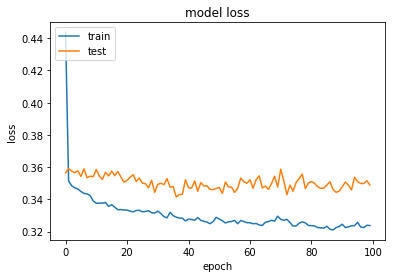

In [13]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

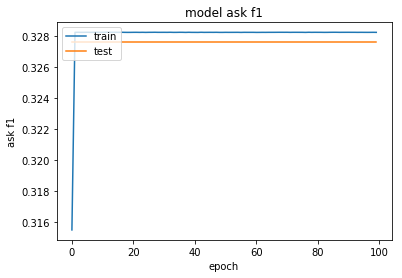

In [14]:
plt.plot(History.history['ask_f1'])
plt.plot(History.history['val_ask_f1'])
plt.title('model ask f1')
plt.ylabel('ask f1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

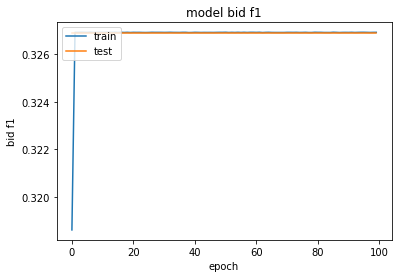

In [15]:
plt.plot(History.history['bid_f1'])
plt.plot(History.history['val_bid_f1'])
plt.title('model bid f1')
plt.ylabel('bid f1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# Remark

Obviously, the model is underfitted and most of the predition just simply gives a "unchanged" for the next timestamp movement. However, due to access reason, we cannot acquire more data at this stage.

To build a more practical model, we may need more stock/trading day/adequate frequency, and also we can train different models with large tick and small tick stocks. What this notebook demostrates is not the result - but the potential use of RNN (or LSTM), combining the limit order book status, to predict the next step price movement, which should be able to improve high frequency trading strategy.